Ομάδα 4

Νίκος Χάιδος, AM: 03118096

Αργύρης Μανέτας, AM:            03117019

Ελευθέριος Λυμπερόπουλος, AM:   03117061

In [ ]:
import numpy as np 
import pandas as pd 

import tensorflow as tf

import gc
import os
import string
import matplotlib.pyplot as plt
import nltk
import collections
import joblib
import random
import numpy as np
import os
import time
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu, corpus_bleu
import json
from PIL import Image
from IPython.display import Image, display
import csv

Αρχικοποιούμε τα seeds των βιβλιοθηκών, για να παίρνουμε ίδια splits, έτσι ώστε να δοκιμάζουμε τα διάφορα μοντέλα, πάνω στο ίδιο validation set.

In [ ]:
random.seed(10)
np.random.seed(10)
tf.random.set_seed(10)

Για τα διαθέσιμα μοντέλα του Gensim, επιλέξαμε το Glove-Twitter-100, καθώς είδαμε ότι τα υπόλοιπα μοντέλα (π.χ. το Google-News που χρησιμοποιήσαμε στην 2η Εργασία), δεν είχαν μερικά stopwords στο λεξιλόγιό τους (π.χ. "a", "the"), τα οποία όμως είναι αναγκαία για την δημιουργία των Image Captions. Όσο για την διάσταση των embeddings, με διάσταση 100, είδαμε ότι βγαίνουν καλά αποτελέσματα.

In [ ]:
import gensim.downloader as api

info = api.info()  # show info about available models/datasets
model = api.load("glove-twitter-100")

[==================================----------------] 68.6% 265.8/387.1MB downloaded


Κατέβασμα των απαραίτητων εικόνων/captions:

In [ ]:
# Download image files

image_zip = tf.keras.utils.get_file('flickr30k-images-ecemod.zip',
                                      cache_subdir="/kaggle/tmp",
                                      origin='https://www.dropbox.com/s/efqe8131slq1zah/flickr30k-images-ecemod.zip?dl=1',
                                      extract=True)
os.remove(image_zip)

4376395776/4376381805 [==============================] - 132s 0us/step


In [ ]:
# Download train captions file
train_captions_file = tf.keras.utils.get_file('train_captions.csv',
                                           cache_subdir="/kaggle/tmp",
                                           origin='https://www.dropbox.com/s/qqrsitwecf7fjd3/train_captions.csv?dl=1',
                                           extract=False)

# Download test files list
test_images_file = tf.keras.utils.get_file('test_images.csv',
                                           cache_subdir="/kaggle/tmp",
                                           origin='https://www.dropbox.com/s/ahtgk6isemsqldf/test_images.csv?dl=1',
                                           extract=False)

40960/29242 [==========================================] - 0s 1us/step


In [ ]:
f = open(train_captions_file, 'r')
annotations = csv.reader(f, delimiter='|')

PATH = '/kaggle/tmp/image_dir'

<function matplotlib.pyplot.show(close=None, block=None)>

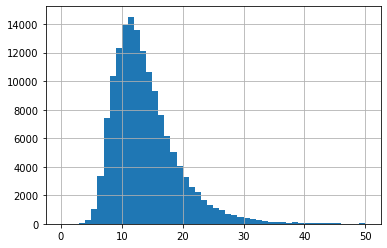

In [ ]:
import matplotlib.pyplot as plt
lengths = []
for val in annotations:
    l = val[2].split()
    lengths.append(len(l))
    
plt.hist(lengths, bins = 50, range=(0, 50))
plt.grid()
plt.show

Όπως βλέπουμε από το διάγραμμα, αρχίζουν να λιγοστεύουν δραματικά τα captions όταν πάμε σε μήκη λίγο μετά από το 30, γι'αυτό επιλέξαμε να κρατήσουμε τα captions που έχουν μήκος από 5 εώς 33 λέξεις.

Επίσης, όσο για το preprocessing των captions, θέλουμε σίγουρα να κρατήσουμε όλα τα stopwords ("a", "the", "with",...), αλλά και όλες τις καταλήξεις σε κάθε λέξη ("playing", "plays", "player",...). Άρα το preprocessing που θα εφαρμόσουμε, θα είναι:
1. Να κάνουμε `lower()` σε κάθε λέξη
2. Να φιλτράρουμε όλα τα σημεία στίξης

In [ ]:
def check_in_model(caption):        # Συνάρτηση για να φιλτράρουμε τα captions τα οποία δεν υποστηρίζονται από το συγκεκριμένο προ-εκπαιδευμένο Embedding_model
  global model
  words = (repr(caption).lower().translate(str.maketrans('', '', string.punctuation))).split()    # Ενά απλό preprocessing οπως εξηγήθηκε παραπάνω
  for word in words:
    try:
      temp = model[word]
    except:
      return False
  return True

In [ ]:
def word_count(s):
    return len(s.split())

f = open(train_captions_file, 'r')
annotations = csv.reader(f, delimiter='|')

annotations = csv.reader(f, delimiter='|')

image_path_to_caption = collections.defaultdict(list)
i = 0
for val in annotations:
  cap_length = word_count(val[2])
  if cap_length < 5 or cap_length > 33: continue                                                                  # Αγνοούμε τα πολύ μικρά και πολύ μεγάλα captions
  if not check_in_model(val[2]): continue                                                                         # Αγνοούμε τα captions που έχουν λέξεις που δεν ανήκουν στο μοντέλο
  caption = f"<start> {repr(val[2]).lower().translate(str.maketrans('', '', string.punctuation))} <end>"          # Προσθέτουμε τα <start> και <end> tokens, αναγκαία για την εκπαίδευση του μοντέλου μας
  image_path = PATH + '/' + val[0]                                                                                # Και δημιουργούμε τα κατάλληλα paths προς τις εικόνες
  image_path_to_caption[image_path].append(caption)
f.close()

In [ ]:
image_paths = list(image_path_to_caption.keys())

In [ ]:
len(image_paths)

29771

Άρα, συνολικά έχουμε 29771 διαφορετικές εικόνες. Ένα παράδειγμα εικόνας και αντίστοιχων captions:

In [ ]:
image_path_to_caption[image_paths[40]]

['<start>  four musicians  wearing scottish garments  are playing instruments on the street  two accordion  one horn  and one clarinet  <end>',
 '<start>  four older men are playing musical instruments in a park by a wall in traditional costume  <end>',
 '<start>  four men dressed in a specific a traditional outfit while playing musical instruments  <end>',
 '<start>  four musicians wearing some kind of european garb are playing in the street  <end>',
 '<start>  four males playing music in a band  <end>']

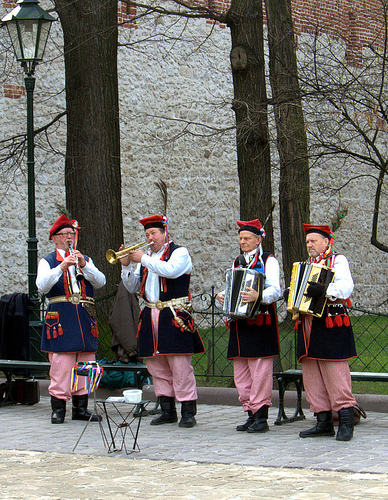

In [ ]:
Image(image_paths[40])

<start>  some people are waiting in line for a street vendor  <end>


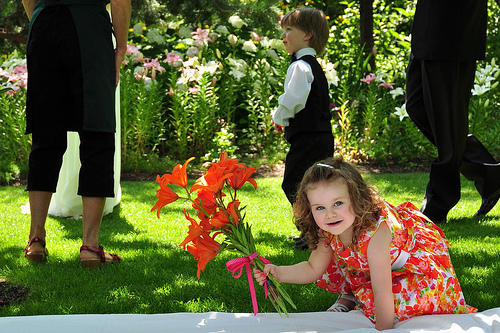

In [ ]:
train_captions = []
img_name_vector = []
n_images = 29771                # Όλο το dataset
for image_path in image_paths[:n_images]:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

print(train_captions[100])
Image(img_name_vector[0])

Ύστερα, φορτώνουμε το προ-εκπαιδευμένο μοντέλο που αντιστοιχεί στην ομάδα μας (NASNetLarge), και τροποποιούμε την συνάρτηση προεπεξεργασίας της εικόνας, για να ταιριάζει στα inputs του NASNetLarge.

Το μοντέλο NASNetLarge, το φορτώνουμε χωρίς το classification_head, και με τα προεκπαιδευμένα βάρη από το Imagenet.

In [ ]:
#NASNetLarge preprocessing

def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(331, 331)(img)
    img = tf.keras.applications.nasnet.preprocess_input(img)
    return img, image_path

In [ ]:
image_model = tf.keras.applications.NASNetLarge(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

2022-02-28 22:24:49.187726: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-28 22:24:49.294730: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-28 22:24:49.295459: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-28 22:24:49.296582: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

343621632/343610240 [==============================] - 2s 0us/step


In [ ]:
# Get unique images

encode_train = sorted(set(img_name_vector))

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)
print(len(image_dataset))

1861


Αφού φορτώσου και κάνουμε preprocess κάθε εικόνα του dataset, την παιρνάμε από το NASNetLarge, και αποθηκεύουμε το αποτέλεσμα σε αρχεία .npy

In [ ]:
%%time

for img, path in image_dataset:
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

2022-02-28 22:25:46.226739: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-28 22:25:47.101121: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


CPU times: user 14min, sys: 59.9 s, total: 15min
Wall time: 14min 47s


Μετά, θα κάνουμε tokenize το λεξιλόγιο από τα captions που έχουμε κρατήσει εν τέλει για εκπαίδευση. Βάλαμε, για μέγισο μέυεθος λεξιλογίου το 25000, αλλά όπως βλέπουμε παρακάτω, μετά από το φιλτράρισμα των captions, τελικά έχουν μείνει περίπου 16000 μοναδικά tokens.

In [ ]:
caption_dataset = tf.data.Dataset.from_tensor_slices(train_captions)

# We will override the default standardization of TextVectorization to preserve
# "<>" characters, so we preserve the tokens for the <start> and <end>.
def standardize(inputs):
  inputs = tf.strings.lower(inputs)
  return tf.strings.regex_replace(inputs,
                                  r"!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~", "")

max_length = 50
# Use the top 25000 words for a vocabulary.
vocabulary_size = 25000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    output_sequence_length=max_length)
# Learn the vocabulary from the caption data.
tokenizer.adapt(caption_dataset)

In [ ]:
tokenizer.vocabulary_size()

15904

In [ ]:
# Create the tokenized vectors
cap_vector = caption_dataset.map(lambda x: tokenizer(x))

Δημιουργούμε αντιστοιχίσεις, από την λέξη στο index του λεξικού, και αντίστροφα.

In [ ]:
# Create mappings for words to indices and indicies to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

Ύστερα, σπάμε το dataset σε training και validation, 80% και 20%, αντίστοιχα, των συνολικών δεδομένων.

Επίσης, επειδή γίνεται ένα shuffle μετά στα train και val sets, κάνουμε load μία συγκεκριμένη λίστα train και val sets, έτσι ώστε να εκπαιδεύουμε και να ελέγχουμε τα μοντέλα μας στα ίδια δεδομένα, για να γίνεται έγκυρη σύγκριση μεταξύ τους.

In [ ]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using a random split.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

#80-20 VALIDATION SET
slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

# Φορτώνουμε συγκεκριμένα train και val sets κάθε φορά
img_name_train_keys = joblib.load("../input/train-val-pickles/img_paths_train.pkl")
img_name_val_keys = joblib.load("../input/train-val-pickles/img_paths_val.pkl")


img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [ ]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(111722, 111722, 27941, 27941)

Για τις αρχικές υπερπαραμέτρους που φαίνονται παρακάτω:
- Το BATCH_SIZE, είδαμε ότι δεν είχε μεγάλη διαφορά στα training times, γι'αυτό το αφήσαμε 64
- Το BUFFER_SIZE του shuffle, δεν το χρησιμοποιήσαμε, γιατί παρατηρήσαμε ένα bug σε όλα τα μέλη της ομάδας, όπου το shuffle άνοιγε έναν buffer για να ανακατέψει τα δεδομένα αλλά δεν τον έκλεινε, με αποτέλεσμα να ξεμένουμε από RAM μετά απο 3-4 εποχές, και να πετάει error το notebook. Περισσότερα για το bug μπορείτε να δείτε [εδώ](https://github.com/tensorflow/tensorflow/issues/44176)
- Το embedding_dim, ίσο με 100, ακολουθώντας την επιλογή μοντέλου που έγινε στην αρχή του notebook
- units ίσο με 256. Αυτή η τιμή είδαμε ότι βγάζει τα καλύτερα αποτελέσματα, όταν εφαρμόζεται σε LSTM, θα ξανα-αναφερθούμε σε αυτό παρακάτω όταν συγκρίνουμε τα μοντέλα.

In [ ]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 100
units = 256
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from NASNetLarge is (121, 4032)
# These two variables represent that vector shape
features_shape = 4032
attention_features_shape = 121

In [ ]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int64]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

2022-02-28 22:48:26.570234: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 44688800 exceeds 10% of free system memory.


Το Attention Module και τον Encoder, το αφήσαμε ίδιο, όπως είχε γραφτεί και στο tutorial της Tensorflow.

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x, training=False):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

Για τον Decoder, με σκοπό να του φορτώσουμε τα προεκπαιδευμένα embeddings, δημιουργούμε έναν πίνακα `embedding_matrix`, ο οποίος έχει όσες γραμμές όσα και τα tokens του vocabulary (15904), και στήλες, όσες η διάσταση των embeddings (100). 

Ύστερα, φορτώνουμε αυτόν τον πίνακα σε ένα `keras.layers.Embedding`, με argument `trainable=False`, για να μην αλλάζουν τα pretrained embeddings.

Επίσης, όπως φαίνεται και στον κώδικα, βάλαμε ειδικές περιπτώσεις embeddings για τα \<start>, \<end>, \[UNK] και \""(κενό). Το κενό, εν τέλει δεν έχει σημασία τι τιμές θα έπαιρνε, διότι το preprocessing στα captions, εξασφαλίζει ότι δεν θα δει ποτέ το κενό token, το μοντέλο μας.

In [ ]:
%%time
embedding_matrix = np.zeros((tokenizer.vocabulary_size(), 100))
print(f"Making embedding_matrix for {tokenizer.vocabulary_size()} tokens")
for index in range(tokenizer.vocabulary_size()):
    temp = tf.compat.as_text(index_to_word(int(index)).numpy())
    if temp == "<start>":
      embedding_matrix[index] = np.full((100,), 0, dtype='float32')
    elif (temp == "<end>"):
      embedding_matrix[index] = np.full((100,), 1, dtype='float32')
    elif (temp == '[UNK]') or (temp == ""):
      embedding_matrix[index] = np.full((100,), 0.5, dtype='float32')
    else:
      #print(tf.compat.as_text(index_to_word(i[0]).numpy()))
      embedding_matrix[index] = model[temp]
    if index % 1000 == 0: print(f"{index} tokens done")

#joblib.dump(embedding_matrix, "embedding_matrix.pkl")        # Αποθήκευση του embedding_matrix, γιατί, προφανώς δεν χρειάζεται να το υπολογίζουμε σε κάθε notebook (αφού έχουμε τα ίδια captions)

Making embedding_matrix for 15904 tokens
0 tokens done
1000 tokens done
2000 tokens done
3000 tokens done
4000 tokens done
5000 tokens done
6000 tokens done
7000 tokens done
8000 tokens done
9000 tokens done
10000 tokens done
11000 tokens done
12000 tokens done
13000 tokens done
14000 tokens done
15000 tokens done
CPU times: user 5min 32s, sys: 4.09 s, total: 5min 36s
Wall time: 5min 36s


Όσο για το μοντέλο του decoder, εδώ έχουμε βάλει αυτό που έδωσε τα καλύτερα αποτελέσματα στο validation set. Ουσιαστικά, οι αλλαγές που έχουμε κάνει από το αρχικό notebook του TensorFlow Tutorial, είναι η αλλαγή από GRU σε LSTM, η χρήση 256 units αντί για 512, και η πρόσθεση δύο Dropout layers πριν από τα Dense Layers `fc1` και `fc2`. Το Drop Rate είναι ίσο με 0.2

In [ ]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.lstm = tf.keras.layers.LSTM(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.dropout = tf.keras.layers.Dropout(0.2)

    self.embedding = tf.keras.layers.Embedding(tokenizer.vocabulary_size(), 
                                               embedding_dim, 
                                               embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                               trainable=False)
    
    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden, training=False):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)


    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, hidden_state, _ = self.lstm(x)
    if training:
          output = self.dropout(output)
    
    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)
    if training:
          x = self.dropout(x)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, hidden_state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

Αρχικοποίηση encoder, decoder και optimizer

In [ ]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, tokenizer.vocabulary_size())

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
loss_plot = []            # Σε αυτήν την λίστα θα αποθηκεύουμε τα losses της κάθε εποχής

Ίδια συνάρτηση train_step με το TensorFlow Tutorial

In [ ]:
#@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([word_to_index(tf.convert_to_tensor('<start>'))] * target.shape[0], 1)
  
  with tf.GradientTape() as tape:
      features = encoder(img_tensor, training=True)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden, training=True)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

Παρακάτω, βλέπουμε ότι σε κάθε εποχή σώζουμε τα εκπαιδευμένα βάρη του encoder και του decoder, αλλά σώζουμε και την κατάσταση του optimizer, έτσι ώστε αν θέλουμε να συνεχίζουμε το training από μία μεταγενέστερη εποχή, ο optimizer να κάνει τα βέλτιστα "βήματα" με βάση όλες τις αλλαγές που έχουν ήδη προηγηθεί στα βάρη.

Επίσης, λόγω του Max-12-Ώρες που δίνει το Kaggle σε κάθε notebook, τα αποτελέσματα που φαίνονται εδώ, είναι για τις πρώτες 20 εποχές, αλλά γενικά συνεχίζαμε το training και μεταγενέστερα, σε άλλα Sessions.

In [ ]:
EPOCHS = 35
start_epoch = 0

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0
    
    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 400 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
            
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    encoder_saver = f"encoder_weights_epoch_{epoch+1}.pkl"
    decoder_saver = f"decoder_weights_epoch_{epoch+1}.pkl"
    optimizer_state_saver = f"optimizer_weights_epoch_{epoch+1}.pkl"
    joblib.dump(encoder.get_weights(), encoder_saver)
    joblib.dump(decoder.get_weights(), decoder_saver)
    joblib.dump(optimizer.get_weights(), optimizer_state_saver)

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')
    
    if time.time()-initial_start >= 37800:
        break

2022-02-28 22:57:45.391001: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 44688800 exceeds 10% of free system memory.


Epoch 1 Batch 0 Loss 2.5787
Epoch 1 Batch 400 Loss 1.2288
Epoch 1 Batch 800 Loss 1.0825
Epoch 1 Batch 1200 Loss 1.1419
Epoch 1 Batch 1600 Loss 1.0447
Epoch 1 Loss 1.148631
Time taken for 1 epoch 1762.63 sec



2022-02-28 23:27:08.068332: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 44688800 exceeds 10% of free system memory.


Epoch 2 Batch 0 Loss 0.9713
Epoch 2 Batch 400 Loss 0.9717
Epoch 2 Batch 800 Loss 0.9522
Epoch 2 Batch 1200 Loss 1.0250
Epoch 2 Batch 1600 Loss 0.9776
Epoch 2 Loss 0.951013
Time taken for 1 epoch 1771.81 sec



2022-02-28 23:56:39.881250: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 44688800 exceeds 10% of free system memory.


Epoch 3 Batch 0 Loss 0.9222
Epoch 3 Batch 400 Loss 0.8949
Epoch 3 Batch 800 Loss 0.8973
Epoch 3 Batch 1200 Loss 0.9913
Epoch 3 Batch 1600 Loss 0.9348
Epoch 3 Loss 0.898750
Time taken for 1 epoch 1773.38 sec



2022-03-01 00:26:13.261818: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 44688800 exceeds 10% of free system memory.


Epoch 4 Batch 0 Loss 0.8881
Epoch 4 Batch 400 Loss 0.8660
Epoch 4 Batch 800 Loss 0.8613
Epoch 4 Batch 1200 Loss 0.9444
Epoch 4 Batch 1600 Loss 0.8965
Epoch 4 Loss 0.866624
Time taken for 1 epoch 1772.23 sec

Epoch 5 Batch 0 Loss 0.8720
Epoch 5 Batch 400 Loss 0.8419
Epoch 5 Batch 800 Loss 0.8402
Epoch 5 Batch 1200 Loss 0.9172
Epoch 5 Batch 1600 Loss 0.8795
Epoch 5 Loss 0.843369
Time taken for 1 epoch 1796.14 sec

Epoch 6 Batch 0 Loss 0.8526
Epoch 6 Batch 400 Loss 0.8175
Epoch 6 Batch 800 Loss 0.8248
Epoch 6 Batch 1200 Loss 0.8994
Epoch 6 Batch 1600 Loss 0.8452
Epoch 6 Loss 0.824758
Time taken for 1 epoch 1800.92 sec

Epoch 7 Batch 0 Loss 0.8415
Epoch 7 Batch 400 Loss 0.7966
Epoch 7 Batch 800 Loss 0.8048
Epoch 7 Batch 1200 Loss 0.8950
Epoch 7 Batch 1600 Loss 0.8402
Epoch 7 Loss 0.809795
Time taken for 1 epoch 1780.82 sec

Epoch 8 Batch 0 Loss 0.8286
Epoch 8 Batch 400 Loss 0.7770
Epoch 8 Batch 800 Loss 0.7881
Epoch 8 Batch 1200 Loss 0.8722
Epoch 8 Batch 1600 Loss 0.8370
Epoch 8 Loss 0.797

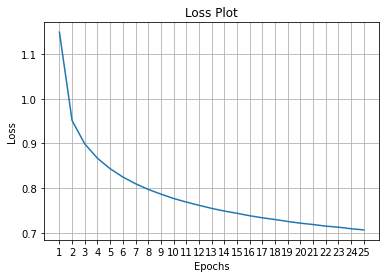

In [ ]:
loss_plot = joblib.load("../input/lstm-dataset/losses.pkl")     # φορτώνω τα losses και για τις 25 εποχές
plt.plot(range(1, len(loss_plot)+1), loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.xticks(range(1, len(loss_plot)+1))
plt.grid()
plt.show()

Παραπάνω, έχουμε το διάγραμμα Loss για τις 25 εποχές στις οποίες εκπαιδεύσαμε συνολικά το μοντέλο. Βλέπουμε ότι ενώ το Loss μειώνεται σε κάθε εποχή, μετά την εποχή 13-14 η μείωση είναι σχετικά μικρή. Αυτό θα φανεί παρακάτω, και στο BLEU Plot, όπου θα δούμε ότι δεν υπάρχει κάποια σημαντική αύξηση.

Όσο για την υλοποίηση του Beam Search, φτιάξαμε την δική μας συνάρτηση, η οποία, σε κάθε βήμα περνάει το κάθε Beam από τον decoder, αποθηκεύει τα predictions και τα hidden states, και υπολογίζει τις συνολικές καλύτερες log πιθανότητες (περνώντας ένα softmax στα predictions, και μετά ένα log), και κρατάει τα νέα καλύτερα Beams.

Περισσότερες λεπτομέρειες της υλοποίησης, και των βημάτων που εκτελούνται, είναι στα σχόλια της παρακάτω συνάρτησης

In [ ]:
def evaluate_beam_search(image, beam_width=5):

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val, training=False)

    dec_input = tf.expand_dims([word_to_index(tf.convert_to_tensor('<start>'))], 0)      # αρχικό input

    beam_seq = np.zeros((beam_width, max_length), dtype=np.int32)                         # κρατάει τις "προτάσεις" που έχει φτιάξει κάθε beam
    beam_log_probs = np.zeros((beam_width, 1))                                            # κρατάει ολική log πιθανότητα της πρότασης, για κάθε beam
    log_prob_char_given_prev = np.empty((beam_width, tokenizer.vocabulary_size()))        # κρατάει log πιθανότητα της κάθε νέας λέξης(prediction), για κάθε beam
    hidden_states = np.empty((beam_width, units))                                         # κρατάει τα τωρινά hidden states για κάθε beam

    final_result = []                                                                     # Κρατάει την τελική απάντηση, δηλαδή τελικά τα καλύτερα beams

    for i in range(max_length):

        if i==0:
          predictions, hidden, _ = decoder(dec_input, features, hidden, training=False)
          
          log_prob_first_char = np.log(tf.nn.softmax(predictions).numpy())                # Αρχικά παίρνουμε τις log πιθανότητες για κάθε λέξη μετά από το token <start>
          temp = np.argsort(log_prob_first_char)
          temp = temp[0, -beam_width:]                                                    # βρίσκουμε τα πρώτα υποψήφια beams
          top_n = np.flip(temp)
          log_prob_top_n = np.take(log_prob_first_char, top_n)                            # Παίρνουμε τις log πιθανότητες από αυτά τα beams
          beam_seq[:, 0] = top_n                                                          # Για κάθε beam αποθηκεύουμε την πρώτη λέξη
          beam_log_probs[:, 0] = log_prob_top_n                                           # προσθέτουμε την log πιθανότητα της νέας λε΄ξης, στην ολική log πιθανότητα της πρότασης του beam
          hidden_states = np.tile(hidden.numpy(), (beam_width,1))                         # αποθηκεύουμε τα hidden states για κάθε beam (για το πρώτο iteration, όλα θα έχουν το ίδιο hidden state)


        if i!=0:
          to_delete=[]
          for beam in range(beam_width):
            
            preds, hidden_states[beam,:], _ = decoder(tf.expand_dims([beam_seq[beam, i-1]], 0), features, np.expand_dims(hidden_states[beam, :], 0), training=False) # Για κάθε beam, βάζουμε το δικό της τελευταίο-token και hidden state σαν είσοδο στον decoder
            log_prob_char_given_prev[beam, :] = np.log(tf.nn.softmax(preds).numpy())            # υπολογίζουμε τις log πιθανότητες των καινούριων token για κάθε beam

          log_prob_char = beam_log_probs + log_prob_char_given_prev                             # υπολογίζουμε τις ολικές log πιθανότητες των νέων υποψήφιων προτάσεων για κάθε beam
          top_n = np.transpose(np.vstack(np.unravel_index(np.argsort(log_prob_char, axis=None), log_prob_char.shape)))
          
          top_n = (np.flip(top_n, 0))[:beam_width, :]                                           # επιλέγουμε τις μεγαλύτερες πιθανότητες, για να είναι τα επόμενα beams

          
          new_beam_seq = np.zeros((0, max_length), dtype=np.int32)                              # Θα αποθηκεύσουμε προσωρινά τα στοιχεία των νέων beams σε αυτούς τους πίνακες, και θα τους φορτώσουμε στο τέλος του iteration
          new_beam_log_probs = np.zeros((0, 1)) 
          new_hidden_states = np.empty((0, units))

          for new_beam in range(beam_width):
            if top_n[new_beam, 1] == word_to_index(tf.convert_to_tensor("<end>")).numpy() or top_n[new_beam, 1] == word_to_index(tf.convert_to_tensor("")).numpy():   # Έλεγχος, σε περίπτωση που ένα beam τερμάτισε με token <end>
              if not final_result:
                final_result = ((beam_seq[top_n[new_beam, 0]].tolist())[:i], beam_log_probs[top_n[new_beam, 0], 0])

              else:
                if final_result[1] < beam_log_probs[top_n[new_beam, 0], 0]:
                  final_result = ((beam_seq[top_n[new_beam, 0]].tolist())[:i], beam_log_probs[top_n[new_beam, 0], 0])
              
              beam_width = beam_width-1
              log_prob_char_given_prev = np.empty((beam_width, tokenizer.vocabulary_size()))
              to_delete.append(top_n[new_beam, 0])
              if beam_width==0:
                return list(map(lambda x: tf.compat.as_text(index_to_word(x).numpy()), final_result[0]))

            else:
              new_beam_seq = np.insert(new_beam_seq, 0, beam_seq[top_n[new_beam, 0]], 0)
              new_beam_seq[0, i] = top_n[new_beam, 1]

              new_beam_log_probs = np.insert(new_beam_log_probs, 0, log_prob_char[top_n[new_beam, 0], top_n[new_beam, 1]], 0)
              new_hidden_states = np.insert(new_hidden_states, 0, hidden_states[top_n[new_beam, 0]], 0)
              

          beam_seq = new_beam_seq
          hidden_states = new_hidden_states
          beam_log_probs = new_beam_log_probs

    if final_result:
      return list(map(lambda x: tf.compat.as_text(index_to_word(x).numpy()), final_result[0]))          # Επιστρέφουμε τα καλύτερα beams Που βρέθηκαν στον χώρο αναζήτησης
    else:
      final_result = beam_seq[np.argmax(beam_log_probs, axis=0)].tolist()
      return list(map(lambda x: tf.compat.as_text(index_to_word(x).numpy()), final_result[0]))

Χρησιμοποιώντας το παραπάνω μοντέλο, και την συνάρτηση `evaluate_beam_search` με `beam_width=5`, βλέπουμε παρακάτω μερικά παραδείγματα καλού Captioning στο validation set, και μερικά παραδείγματα μέτριου Captioning στο validation set:

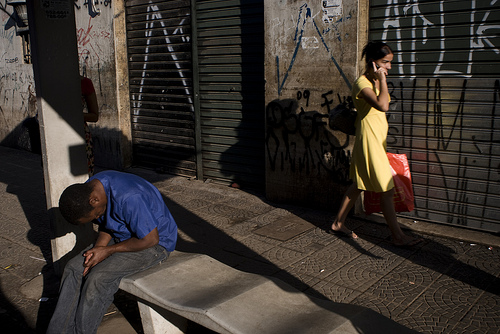

a man in a blue shirt is standing on a sidewalk


0.6226583097209265

In [ ]:
index = 0
sentence_bleu_from_img_paths(img_name_val[index], verbosity=True)

Εδώ βλέπουμε ότι έχει καταφέρει να εντοπίσει τόσο το posture του άντρα (καθιστός), όσο και το χρώμα της μπλούζας του (μπλε).

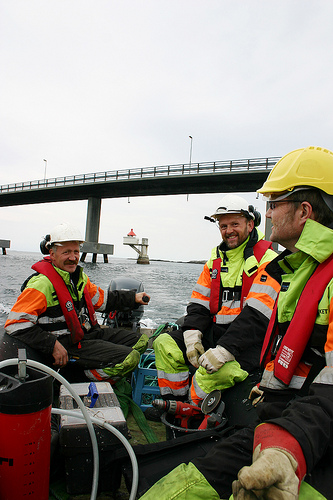

a group of men in hard hats


0.2934123534052107

In [ ]:
index = 31
sentence_bleu_from_img_paths(img_name_val[index], verbosity=True)

Εδώ, ο λόγος που συμπεριλάβαμε αυτό το Caption, είναι επειδή το μοντέλο, κατάφερει να εντοπίσει τα προστατευτικά κράνη που φοράνε οι διασώστες.

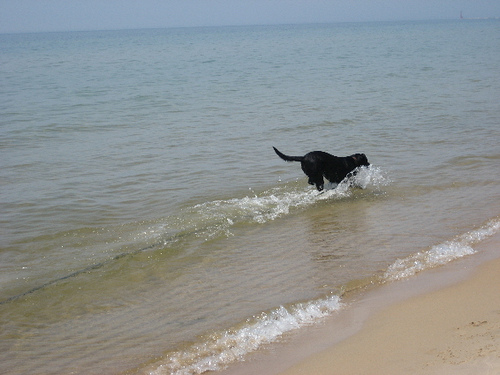

a black dog runs through the ocean


0.8271628750638266

In [ ]:
index = 54
sentence_bleu_from_img_paths(img_name_val[index], verbosity=True)

Εδώ, όπως φαίνεται και στο BLEU Score της εικόνας, έχει καταλάβει όλα τα πράγματα που απεικονίζονται στην εικόνα, δηλαδή την θάλασσα, τον σκύλο, αλλά και το posture του σκύλου (τρέχει).

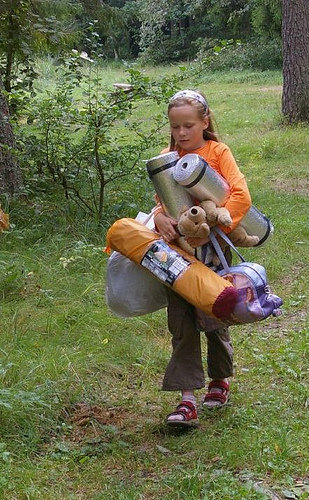

a young boy wearing a blue shirt is sitting in a park


0.08711108976507889

In [ ]:
index = 38
sentence_bleu_from_img_paths(img_name_val[index], verbosity=True)

Έδω έχουμε ένα αποτυχημένο Caption, καθώς βλέπουμε ότι δεν αναφέρει τίποτα για τα πράγματα που κρατάει το παιδί, και δεν πέτυχε το σωστό φύλο (boy αντί για girl). Όσο για το χρώμα της μπλούζας, που και αυτό δεν το πέτυχε, πιθανότατα μπερδεύτηκε με τα πράγματα που κρατάει.

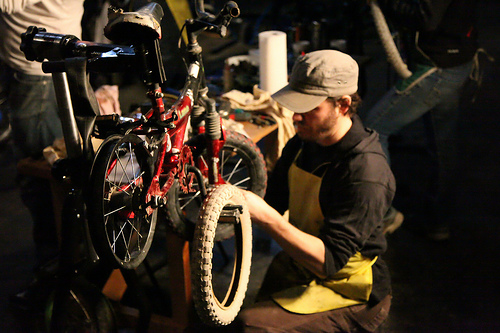

a man is riding a bicycle


0.08841519179058879

In [ ]:
index = 45
sentence_bleu_from_img_paths(img_name_val[index], verbosity=True)

Εδώ, ενώ έχει καταλάβει την ύπαρξη ενός ποδηλάτου στην εικόνα, έχει κάνει λάθος εκτίμηση στην πράξη (εκτίμησε riding, ενώ το fixing/repairing είναι το σωστό).

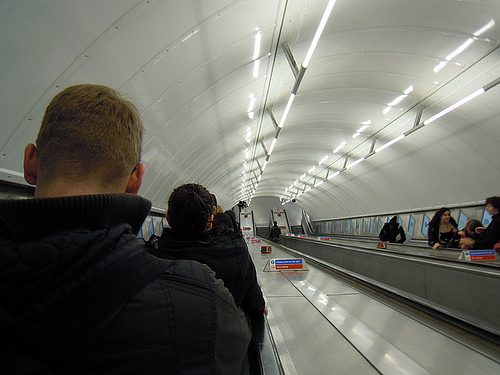

a group of people are standing in a bowling alley


0.14836239104787058

In [ ]:
index = 53
sentence_bleu_from_img_paths(img_name_val[index], verbosity=True)

Στο από πάνω caption, έχει μπερδέψει τη κουπαστή της κυλιόμενης σκάλας, με τον μακρύ διάδρομο στο bowling, γι' αυτό εκτίμησε ότι όλοι αυτοί οι άνθρωποι βρίσκονται σε bowling alley.

Ύστερα, για τον υπολογισμό corpus_bleu και sentence bleu, έχουμε υλοποιήσει τις δύο απλές συναρτήσεις που φαίνονται παρακάτω (και την βοηθητική correct_captions, η οποία αφαιρεί τα \<start> και \<end> tokens), οι οποίες υπολογίζουν τις απαντήσεις που θα δώσει το μοντέλο (με beam_width=5) και τις βάζουν στις έτοιμες συναρτήσεις που δίνει το NLTK (με τα arguments που δώθηκαν από την εκφώνηση της εργασίας).

In [ ]:
def correct_captions(caps):
  ret = [] 
  for index, sent in enumerate(caps):
    ret.append((caps[index].split())[1:-1])
  return ret

def sentence_bleu_from_img_paths(img_path, beam_width=5, verbosity=0):
  if verbosity:
    display(Image(img_path))
  hypothesis = evaluate_beam_search(img_path, beam_width)
  if verbosity:
    print(" ".join(hypothesis))
  return sentence_bleu(correct_captions(image_path_to_caption[img_path]), hypothesis, weights=(0.4,0.3,0.2,0.1), smoothing_function=SmoothingFunction().method1)

def corpus_bleu_from_list(img_paths):
  hypotheses = []
  references = []
  for img in img_paths:
    hypothesis = evaluate_beam_search(img)
    hypotheses.append(hypothesis)
    references.append(correct_captions(image_path_to_caption[img]))
  return corpus_bleu(references, hypotheses, weights=(0.4,0.3,0.2,0.1), smoothing_function=SmoothingFunction().method1)

In [ ]:
%%time
bleu_scores = [joblib.load("../input/bleus_dataset/bleu_scores_1-25.pkl")]
epoch_axis = range(1,26)
for i in range(1, 26):
    st = time.time()
    encoder.set_weights(joblib.load(f"./encoder_weights_epoch_{i}.pkl"))
    decoder.set_weights(joblib.load(f"./decoder_weights_epoch_{i}.pkl"))
    
    temp = corpus_bleu_from_list(img_name_val[:120])
    bleu_scores.append(temp)
    print(f"Epoch {i} score computed in {time.time()-st} sec, bleu = {temp}")
joblib.dump(bleu_scores, "bleu_scores.pkl")

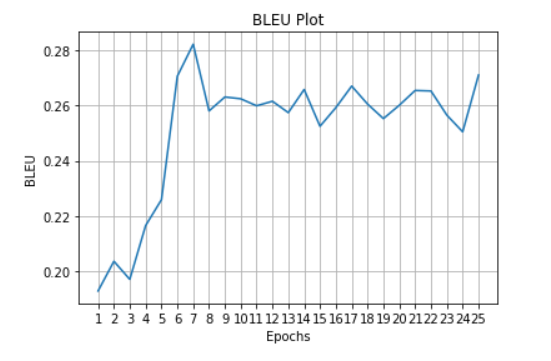

Για την σύγκριση του Corpus_Bleu των διαφόρων εποχών, όπως φαίνεται παραπάνω, συγκρίναμε στις πρώτες 120 εικόνες του validation set (για ολα το μοντελα, χρησιμοποιησαμε ιδιο train και validation set για να ειναι πιο εγκυρη η συγκριση). Επειδή συγκρίναμε αρκετά μοντελά, και το evaluate_beam_search ήταν ήδη αρκετά χρονοβόρο, έπαιρνε κάπου στις 4-5 ώρες για να δημιουργηθεί το παραπάνω plot, γι'αυτό δεν χρησιμοποιήσαμε παραπάνω εικόνες για την συγκρίση των εποχών.

Όσο για το διάγραμμα, βλέπουμε ότι η καλύτερη εποχή είναι η 7, και μετά από την 10 δεν έχουμε κάποια ουσιαστική αύξηση, αλλά μόνο μία ταλάντωση. Αυτό επιβεβαιώνεται και από το Loss Plot που είδαμε νωρίτερα, στο οποίο δεν παρουσιάζεται κάποια σημαντική μείωση του Loss από αυτήν την εποχή και μετά.

Το corpus_bleu του καλύτερου μοντέλου (εποχή 7) σε 2000 εικόνες από το validation set φαίνεται παρακάτω:

(προφανώς, αυτός ο υπολογισμός δεν έγινε σε κάθε μοντέλο, γιατί είναι αρκετά χρονοβόρος)

In [ ]:
corpus_bleu_from_list(img_name_val[:2000])

0.25037239010515994

#Άλλα Μοντέλα που δοκιμάσαμε

####GRU, 512 Units, δύο Dropout Layers με rate 0.4

Το συγκεκριμένο μοντέλο το εκπαιδεύσαμε σε 20 εποχές, και είδαμε ότι σίγουρα το LSTM έβγαζε καλύτερα αποτελέσματα (τόσο σε μεμονωμένες εικόνες, όσο και σε μετρικές Bleu). Το Loss Plot του μοντέλου:

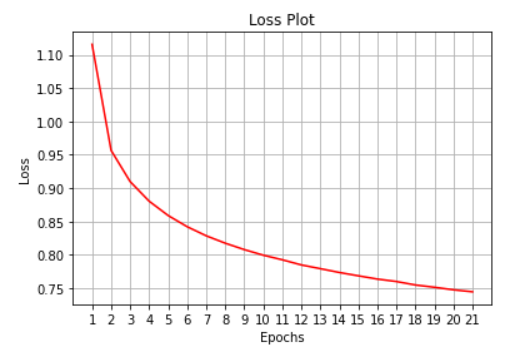

Και το Bleu Plot:

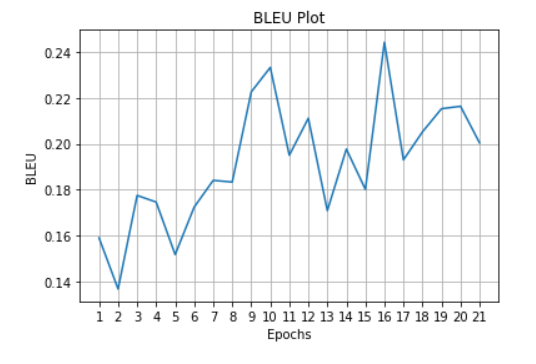

Το Loss, δεν παρουσίαζε σημαντικές αυξήσεις περίπου από την εποχή 10 (όπως και με το μοντέλο με LSTM που παρουσιάσαμε παραπάνω), ενώ βλέπουμε από το BLEU Plot, ότι το μοντέλο με LSTM είχε πετύχει αρκετά καλύτερες μετρικές, ακόμα και σε αρχικές εποχές.

####LSTM, 512 Units, δύο Dropout Layers με rate 0.4

Το επόμενο μοντέλο το εκπαιδεύσαμε σε 14 εποχές και το evaluation (με beam search) του μοντέλου με τα βάρη που προέκυπταν σε κάθε εποχή  έγινε στις πρώτες 120 εικόνες του validation set. Φαίνεται να εμφανίζει καλά αποτελέσματα και το BLEU score παρατηρούμε ότι βρισκόταν σε ανοδική πορεία. Ωστόσο ο χρόνος εκπαίδευσης ήταν πάρα πολύ μεγάλος καθώς οι 7 εποχές χρειάζονταν 12 ώρες εκπαίδευσης.

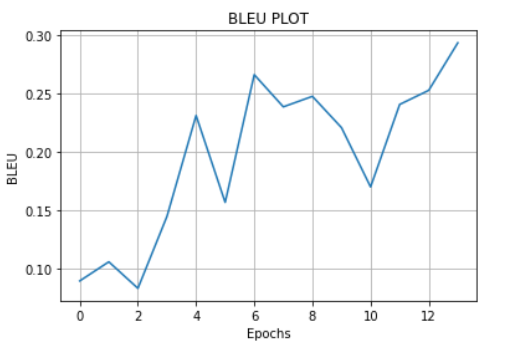